In [20]:
!uv add -q -U google-genai

22483.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [21]:
!uv add -q python-dotenv

22489.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [22]:
from dotenv import load_dotenv

load_dotenv()

True

In [122]:
# API 실행

from google import genai

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

response = client.models.generate_content(
    model="gemini-3-flash-preview", contents="랭체인과 랭그래프의 관계를 설명해줘."
)
print(response.text)

랭체인(LangChain)과 랭그래프(LangGraph)의 관계는 한마디로 **"부모 프레임워크와 이를 확장한 정교한 제어 도구"**라고 설명할 수 있습니다. 

더 자세한 이해를 위해 두 프레임워크의 개념과 차이점, 그리고 왜 함께 쓰이는지를 정리해 드릴게요.

---

### 1. 랭체인 (LangChain)이란?
랭체인은 LLM(거대언어모델) 애플리케이션을 개발하기 위한 가장 대표적인 프레임워크입니다.
*   **핵심 개념:** **'체인(Chain)'**. 여러 작업을 순차적으로 연결하는 것에 최적화되어 있습니다.
*   **특징:** 데이터 검색(RAG), 프롬프트 템플릿 관리, 모델 연결 등을 쉽게 할 수 있도록 다양한 컴포넌트를 제공합니다.
*   **한계:** 기본적으로 **선형적(Linear)**이거나 **비순환적(DAG)**인 구조입니다. 즉, "A → B → C"처럼 정해진 순서대로 흐르는 작업에는 강하지만, "A를 해보고 결과가 안 좋으면 다시 A로 돌아가라" 같은 **반복(Loop)** 구조를 구현하기는 어렵고 복잡했습니다.

### 2. 랭그래프 (LangGraph)란?
랭그래프는 랭체인을 만든 팀에서 발표한 라이브러리로, **랭체인 위에서 구동되는 확장 팩**과 같습니다.
*   **핵심 개념:** **'그래프(Graph)'**. 상태(State)를 가진 그래프 구조를 사용하여 순환(Cycle)을 허용합니다.
*   **특징:** 
    *   **순환 구조(Cycles):** 에이전트가 작업을 수행하다가 스스로 오류를 수정하거나, 추가 정보가 필요하면 이전 단계로 돌아갈 수 있습니다.
    *   **상태 관리(State Management):** 대화 내용이나 작업 진행 상황을 세밀하게 기억하고 관리합니다.
    *   **세밀한 제어:** 기존 랭체인의 'AgentExecutor'보다 훨씬 더 정교하게 에이전트의 행동을 설계할 수 있습니다.

---

### 3. 둘의 관계 요약

| 구분 | 랭체인 (LangChain) 

In [24]:
!uv add -U langgraph

22563.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 47 packages in 178ms                                        
Audited 46 packages in 10ms


In [25]:
!uv add -U langchain

22569.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 47 packages in 99ms                                         
Audited 46 packages in 5ms


In [26]:
!uv add -U langchain-google-genai

22575.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 47 packages in 87ms                                         
Audited 46 packages in 0.89ms


### 1. Model 및 Tool 정의


In [123]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
)

In [28]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """MUltiply `a` and `b`.
    
    Args:
        a: First int
        b: Second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.
    
    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.
    
        Args:
            a: First int
            b: Second int
    """
    return a / b

In [124]:
# tools 정의
tools = [multiply, add, divide]

In [125]:
model_with_tools = model.bind_tools(tools)

### 2. State 정의

In [102]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    llm_call: int

### 3. Node 정의

In [103]:
from langchain.messages import SystemMessage

def llm_call(state) :
    sys_msg = [SystemMessage(content='당신은 사칙연산을 하는 유능한 Agent입니다.')]

    response = model_with_tools.invoke(sys_msg + state['messages'])
    
    return {
        'messages' : [response],
        'llm_calls' : state.get('llm_calls', 0) + 1
    }

In [104]:
# tool 목록 생성
tools_by_name = { tool.name: tool for tool in tools}

In [105]:
tools_by_name

{'multiply': StructuredTool(name='multiply', description='MUltiply `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x1106f34c0>),
 'add': StructuredTool(name='add', description='Adds `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x1106f3420>),
 'divide': StructuredTool(name='divide', description='Divide `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x1106f3560>)}

In [126]:
# tool_node
from langchain.messages import ToolMessage
def tool_node(state) :

    result = []
    for tool_call in state['messages'][-1].tool_calls:
        tool = tools_by_name[tool_call['name']]
        tool_result = tool.invoke(tool_call['args'])

        result.append(ToolMessage(content=tool_result, tool_call_id=tool_call['id']))
    return {'messages': result}

### 4. Graph 생성

In [127]:
from langgraph.graph import StateGraph, START

agent_builder = StateGraph(MessagesState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START, 'llm_call')
agent_builder.add_edge('tool_node', 'llm_call')

In [128]:
from langgraph.graph import END

def should_continue(state : MessagesState) :
    last_message = state['messages'][-1]
    if last_message.tool_calls :
        return 'tool_node'
    else :
        return END

In [129]:
agent_builder.add_conditional_edges(
    'llm_call',
    should_continue,
    [END, 'tool_node']
)

In [130]:
agent = agent_builder.compile()

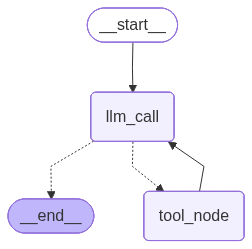

In [131]:
agent

### 실행

In [132]:
from langchain.messages import HumanMessage

messages = [HumanMessage(content="3과 4를 더해줘")]
response = agent.invoke({"messages": messages})

In [134]:
response

{'messages': [HumanMessage(content='3과 4를 더해줘', additional_kwargs={}, response_metadata={}, id='b6196547-92d6-4fd1-90df-883003e3d654'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 4, "a": 3}'}, '__gemini_function_call_thought_signatures__': {'6e0d953d-ba2b-45ab-8013-1aecddab7f44': 'EoUBCoIBAb4+9vtpAty97nYh2BfsdUDhw0YHzWLI+PLf0q3pwdEefhVCV+9BMDT3gz/sN5tUx9uK4a8aJ+nb1OGs9c1GLlYSzD5xw7EaHHvIqOiRqjCByt76hLkpPeg19Gk8wVQZFMuYXrKluzXCoQo+4wCk99ckEoHvB1HNIQdLVeiQJuhHlA=='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c6be6-586d-74f0-96e2-c1709803f637-0', tool_calls=[{'name': 'add', 'args': {'b': 4, 'a': 3}, 'id': '6e0d953d-ba2b-45ab-8013-1aecddab7f44', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 235, 'output_tokens': 47, 'total_tokens': 282, 'input_token_details': {'cache_read': 0}, 'output_token_d

In [135]:
response['messages'][-1].content[-1]['text']

'3과 4를 더하면 7입니다.'

In [136]:
messages = [HumanMessage(content="3과 4를 더한 뒤 7을 곱해줘.")]
response = agent.invoke({"messages": messages})

In [137]:
response['messages'][-1].content[-1]['text']

'3과 4를 더하면 7이고, 여기에 7을 곱하면 49가 됩니다.'

In [138]:
response

{'messages': [HumanMessage(content='3과 4를 더한 뒤 7을 곱해줘.', additional_kwargs={}, response_metadata={}, id='3ec988a4-6bc6-4467-8d1d-d78159fb4673'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3, "b": 4}'}, '__gemini_function_call_thought_signatures__': {'3b51ab97-f7f3-4852-b926-a2fc23f996e4': 'EtsCCtgCAb4+9vsRuGnGvYVmURf6RbMS4PrQQhsY3abnr1nySASOkx+HDuqTXWxVwlAGLZvZ9A5t/DX7jhlhAMEi8uQHNgzD6RvqF4rpsL1ABpM2O8N60RzzaSzS/xCwsdvfJ+276jcuFPpdPxcWl1FCrKlQ5kNvbm1aBix6OdIDxAp11OP/hSE2DXqPMa8vdHjRpQTAEWrJIzBh3QpJU5ESsNJ2sa4q+N0ZJlydVgSqsyKd+nWWGIyoTrtn88i6Lnput1ehJcabvklRXNACofDiCcNrqWCEiEqHqkVmiZpdJl0v6fWZhF2kwwUfabfSxa7Z6DUqNo0PZZ22wx64vps0mAxNs4rQ8hzjOFc0O/sSwCuRwGP9nu9Y7G2Auum3Mr9bTEBAXPBCh+kEWiCIzpN4W2PahW8aj1lBu+fLgJxEnpzhpoMRT9Fd6Z1z6vw/ICq3Jo0kAOmCdDSQQs0='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c6bec-1cb5-7b51-b64a-6c1c40